In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_master = pd.read_csv('Input/Historical Product Demand.csv', sep=",")
df_master.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100


### Preprocessing df_master

In [3]:
df_master.shape

(1048575, 5)

In [4]:
df_master.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [5]:
df_master.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [6]:
df_master.dropna(subset=['Date'], inplace=True)
df_master.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [7]:
df_master.sort_values('Date', ignore_index=True, inplace=True)
df_master.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)


On Order_Demand Column Encountered the Non Numerical df_master with "(",")" needed to handle to extract the numerical value 

In [8]:
df_master['Order_Demand'] = df_master['Order_Demand'].str.replace(r'[^\d.]+', '', regex=True)
df_master.head(2)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,2


### Extract Date

In [9]:
from datetime import datetime as dt

df_master['Date']= pd.to_datetime(df_master['Date'])

df_master['Year'] = df_master["Date"].dt.year
df_master['Month'] = df_master["Date"].dt.month
df_master['Day'] = df_master["Date"].dt.day

df_master.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,Product_0965,Whse_A,Category_006,2011-01-08,2,2011,1,8


In [10]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

cat_cols = [col for col in df_master.columns if df_master[col].dtype == 'object']

for col in cat_cols:
    df_master[col] = lb.fit_transform(df_master[col])

df_master.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,954,0,5,2011-01-08,1021,2011,1,8


In [11]:
monthly_demand = df_master.groupby('Month')['Order_Demand'].sum()


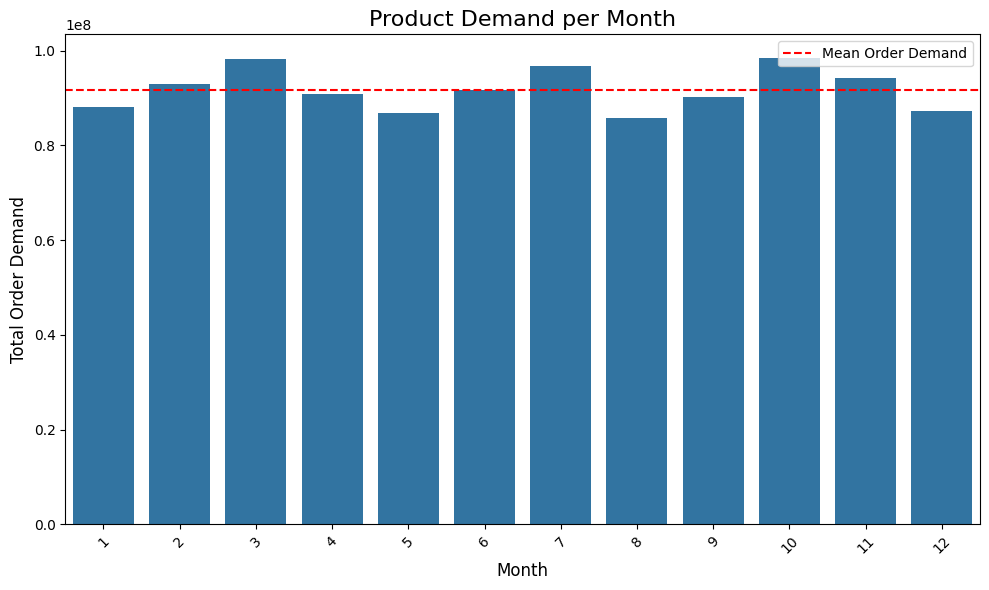

In [12]:
mean_demand = monthly_demand.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_demand.index, y=monthly_demand.values)
plt.axhline(mean_demand, color='red', linestyle='--', label='Mean Order Demand')

plt.title('Product Demand per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Order Demand', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

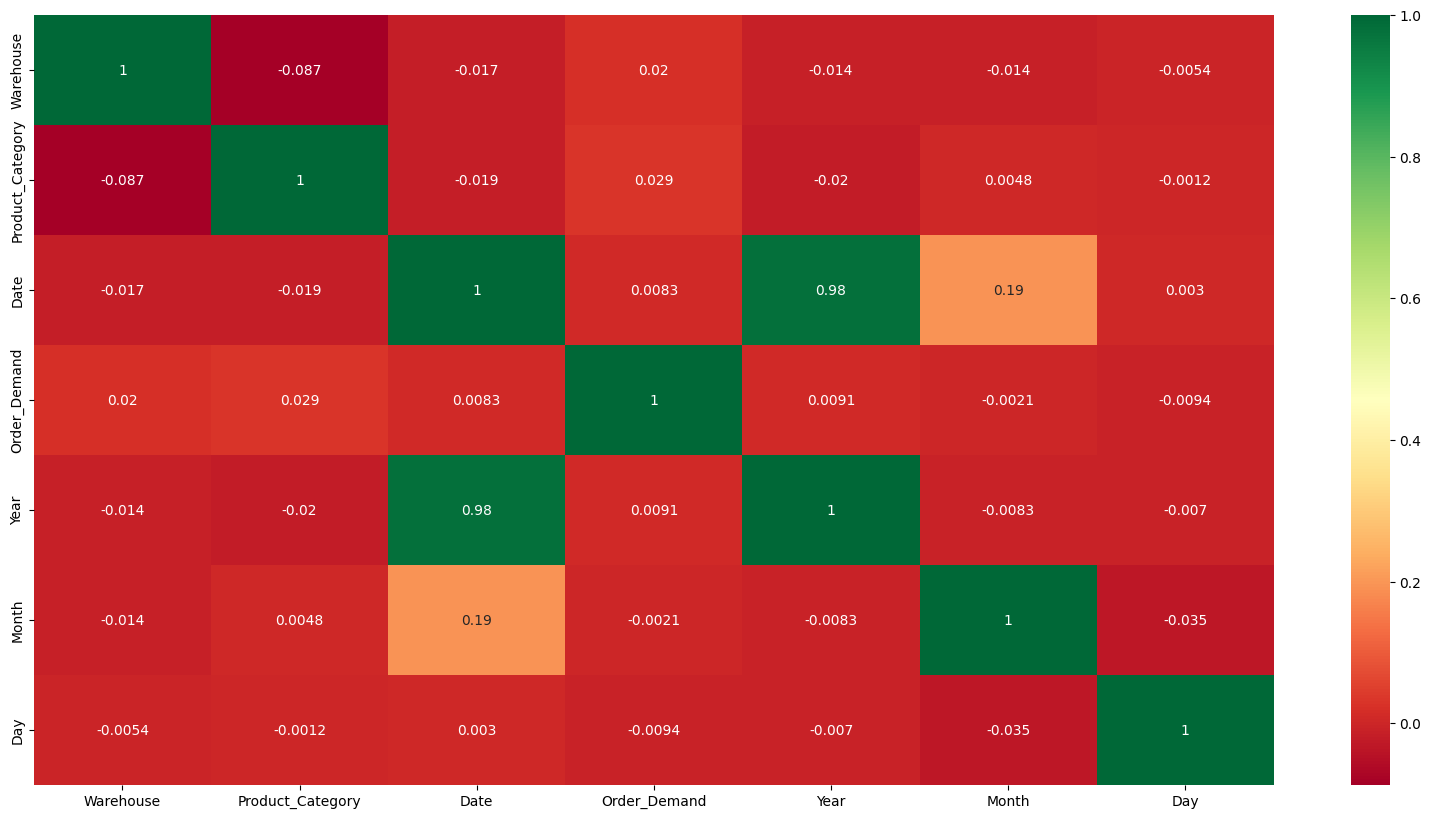

In [13]:
fig = plt.figure(figsize=(20,10))
corrMatrix = df_master[df_master.columns[1:]].corr()

sns.heatmap(corrMatrix,annot=True,cmap ='RdYlGn')
plt.show()

## LSTM Model For Forecasting

In [14]:
import math

df = df_master.groupby('Date')[['Product_Code','Order_Demand']].sum().reset_index()
df

,Date,Product_Code,Order_Demand
0,2011-01-08,954,1021
1,2011-05-31,1713,116
2,2011-06-24,3020,5876
3,2011-09-02,1496,313
4,2011-09-27,2528,3547
...,...,...,...
1724,2017-01-03,1475,3070
1725,2017-01-04,9904,8312
1726,2017-01-05,24162,16690
1727,2017-01-06,22135,21119


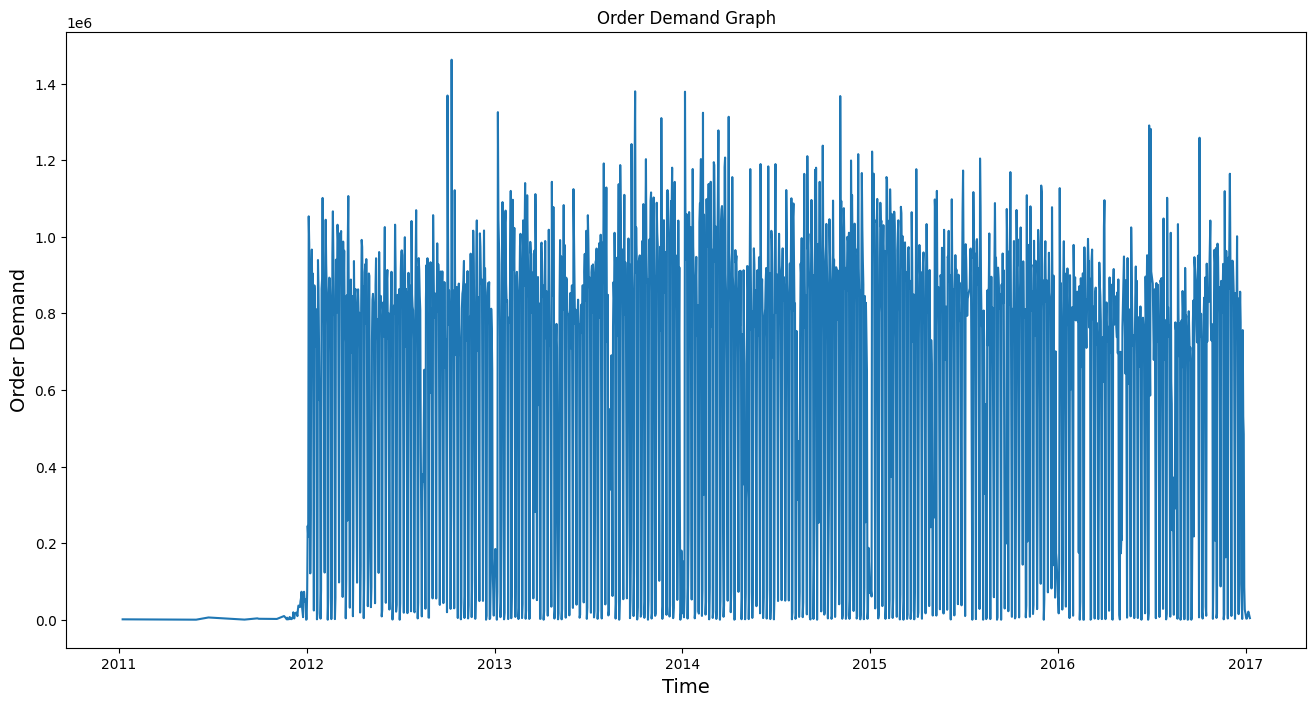

In [15]:
plt.figure(figsize=(16, 8))
plt.title("Order Demand Graph")
plt.plot(df["Date"], df["Order_Demand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [16]:
demand_data = df.filter(['Order_Demand'])

# Changing to List
demand_data_list = demand_data.values

# Define Training Set 80%
training_data_len = math.ceil(len(demand_data_list) * .8)
timestamp_windows = 70

In [17]:
demand_data_list

array([[ 1021],
       [  116],
       [ 5876],
       ...,
       [16690],
       [21119],
       [ 4191]])

In [18]:
from sklearn.preprocessing import MinMaxScaler

#Scale Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(demand_data_list)

scaled_data[1:5]

array([[7.93238327e-05],
       [4.01816242e-03],
       [2.14037583e-04],
       [2.42553133e-03]])

### Model Creation

In [19]:
import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
train_data = scaled_data[0 : training_data_len, :]


# Create X_train and y_train
X_train = []
y_train = []


for i in range(timestamp_windows, len(train_data)):
    X_train.append(train_data[i - timestamp_windows : i, 0])
    y_train.append(train_data[i, 0])

In [21]:
# create the testing dataset
test_data = scaled_data[training_data_len - timestamp_windows : , :]


# create X_test and y_test
X_test = []
y_test = scaled_data[training_data_len : , :]
for i in range(timestamp_windows, len(test_data)):
    X_test.append(test_data[i - timestamp_windows : i, 0])

In [22]:
#Convert to array
x_train,y_train = np.array(X_train), np.array(y_train)
x_test,y_test = np.array(X_test), np.array(y_test)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f'Training : {x_train.shape}, Test : {x_test.shape}')

Training : (1314, 70, 1), Test : (345, 70, 1)


In [39]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(x_train.shape[2]))

early_stopping = EarlyStopping(monitor='mae', patience=5, restore_best_weights=True)
model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])
model.summary()

c:\Users\SYAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 70, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       324,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,753 (1.46 MB)

 Trainable params: 382,753 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(
    x_train, y_train,
    epochs=50, 
    batch_size=30, 
    callbacks=[early_stopping],  
    verbose=1 
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.1165 - mae: 0.2835
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0770 - mae: 0.2401
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0743 - mae: 0.2348
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0752 - mae: 0.2401
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0753 - mae: 0.2383
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0739 - mae: 0.2348
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0754 - mae: 0.2411
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0765 - mae: 0.2402
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0759 - mae: 0.2371
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0727 - mae: 0.2354
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0696 - mae: 0.2272
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0616 - mae: 0.2092
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━

In [41]:
# predict with LSTM model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings

In [43]:
y_test

array([[6.05860390e-01],
       [4.88723707e-02],
       [5.47023989e-01],
       [6.55319484e-01],
       [5.84354058e-01],
       [5.72571050e-01],
       [5.62095517e-01],
       [5.58706474e-02],
       [7.36614787e-01],
       [5.62302032e-01],
       [9.72633278e-02],
       [6.14451982e-01],
       [3.42224213e-01],
       [3.94690774e-02],
       [4.79273913e-01],
       [1.19071911e-01],
       [1.05135534e-01],
       [7.84519544e-02],
       [1.13713449e-02],
       [1.01167975e-01],
       [7.70697366e-01],
       [5.56761673e-01],
       [6.01202166e-01],
       [5.25334391e-01],
       [1.81323340e-02],
       [1.03578462e-01],
       [6.14518313e-01],
       [6.75890342e-01],
       [5.70751388e-01],
       [5.32445499e-01],
       [2.33793320e-02],
       [6.18712219e-01],
       [5.73576958e-01],
       [6.27285347e-01],
       [5.50776143e-01],
       [5.22766624e-01],
       [2.97464373e-03],
       [6.15213764e-01],
       [4.10768210e-01],
       [5.05555404e-01],


In [44]:
#  Model Quality

mse = np.mean((y_test - predictions) ** 2)
rmse = np.sqrt(np.mean(y_test - predictions)**2)

mad = np.mean(np.abs(y_test - predictions))
tracking_signal = np.sum(y_test - predictions) / mad
print(f"Tracking Signal: {tracking_signal}")

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Tracking Signal: -344.95438952245075
Mean Squared Error (MSE): 406401392215.22626
Root Mean Squared Error (RMSE): 604614.4797176849


<function matplotlib.pyplot.show(close=None, block=None)>

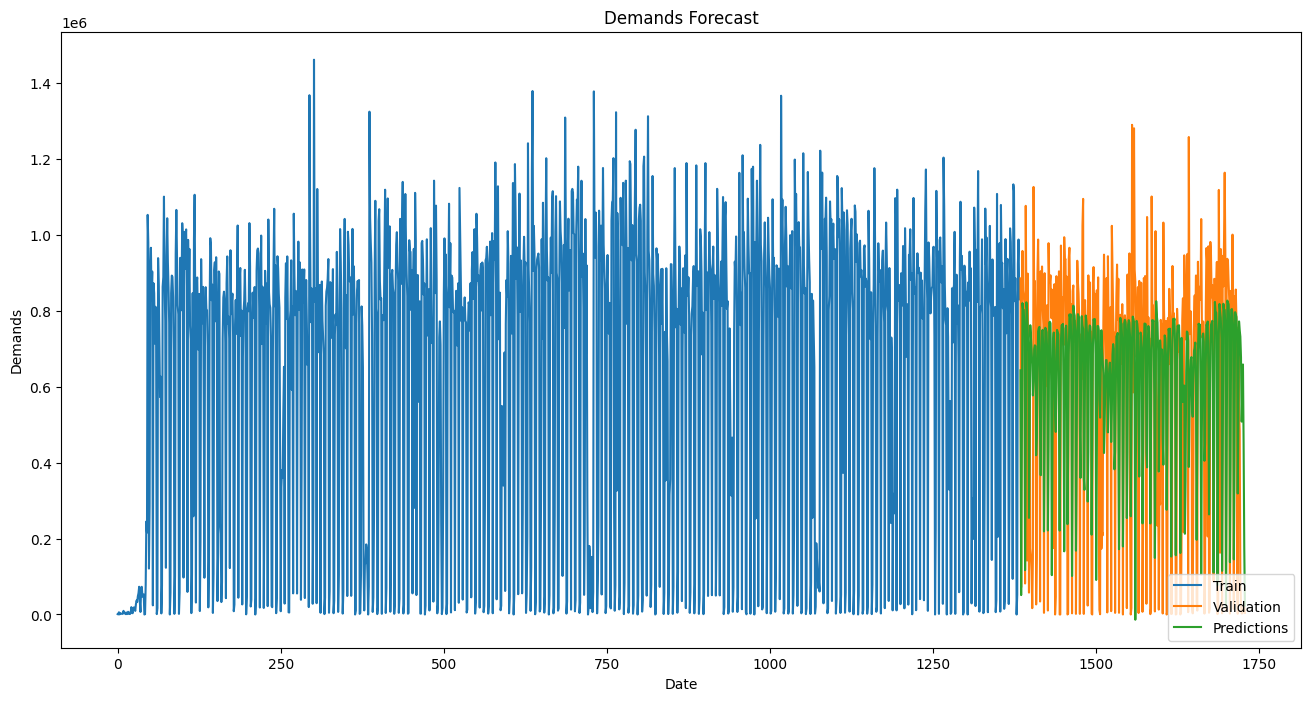

In [ ]:
train = df[:training_data_len]

# Testing Data Defined at Len(Train) - (Len(Train) + Training Size)
valid = df[training_data_len:()]
valid = valid.copy()
valid.loc[:, 'Predictions'] = predictions

#Plot
plt.figure(figsize=(16,8))
plt.title('Demands Forecast')
plt.xlabel('Date')
plt.ylabel('Demands')
plt.plot(train["Order_Demand"])
plt.plot(valid[["Order_Demand",'Predictions']])
plt.legend(['Train','Validation','Predictions'], loc='lower right')
plt.show 

In [46]:
model.save('Output Model/Warehouse Demands/lstm_V2_model.h5')